# Measure contributions of parts of OCR pipeline

## Possible OCR pipelines (actions are green)

![ocr_flow](assets/ocr_flow.drawio.jpg)

#### The are 4 groups of actions in the full pipeline (green boxes). The purpose of this notebook is to test if all of these actions really helps with the OCR results, and if they do, by how much.

- **Find the single best ensemble.**
- Which of the 4 image processing pipelines improve OCR performance?
- Two OCR engines: `Tesseract` & `EasyOCR`. `Tesseract` is the current leader in open source OCR engines, does adding `EasyOCR` improve the results?
- The `combine text` function is only needed if we stick with the ensemble approach. I.e. only if we use more than one image processing pipeline or more than one OCR engine.
- The `clean text` function corrects misspellings and common OCR errors with punctuation, spacing, etc. We want to measure its efficacy.

## Comparison strategy

#### We're doing ablations on the OCR pipeline.
- How well do `Tesseract` and `EasyOCR` perform on their own without image pre-processing. I'll also try the engine directly grafted to the `clean text` function.
- How well do each of the image pre-processing steps help the OCR process? and which ones work well with which OCR engine. I'm going to try various permutations of these.
- Can I whittle this down to one or zero image pre-processing pipelines and one OCR engine? If so, then this would allow me to drop the `combine text` step.
- How much does the `clean text` step help?
- Note that `EasyOCR` uses a fair bit of GPU resources and if we can remove it it will speed up the OCR pipeline significantly. I.e. `EasyOCR` is difficult to parallelize.

#### Scoring
- I'll use an expert derived gold standard to compare against the ablation sequences.
- I am using Levenshtein distance as the scores. Levenshtein distance counts character mismatches between sequences in a best case pairwise alignment.

## Setup

In [81]:
import json
import re
from IPython.display import display, HTML
from collections import defaultdict, namedtuple, Counter
from datetime import datetime
from itertools import groupby
from pathlib import Path
from types import SimpleNamespace

import jinja2
import matplotlib.pyplot as plt
from tqdm import tqdm

from digi_leap.pylib import consts
from digi_leap.pylib.db import db
from digi_leap.pylib.ocr import ocr_compare as compare

In [2]:
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [3]:
GOLD_STD_PATH = consts.DATA_DIR / "sernec" / "gold_std_2022-06-28"

ARGS = SimpleNamespace(
    database=consts.DATA_DIR / "sernec" / "sernec.sqlite",
    gold_set="gold_set_2022-06-28",
    score_set="scores_2022-06-28",
    char_set="default",
    notes="",
    csv_path=GOLD_STD_PATH / "gold_std_2022-06-28.csv",
    out_file=consts.DATA_DIR / "output" / "compare_pipelines_2022-08-15.html",
)

## Gold standard

In [4]:
# Save a new gold standard to a database

# compare.insert_gold_std(ARGS.csv_path, ARGS.database, ARGS.gold_set)

In [5]:
# Read a gold standard from the database

GOLD_STD = compare.select_gold_std(ARGS.database, ARGS.gold_set)
GOLD_DICT = {g["gold_id"]: g for g in GOLD_STD}

## OCR scores

In [6]:
scorer = compare.Scorer(ARGS)

In [7]:
# Calculate new scores

# SCORES = scorer.calculate(GOLD_STD)
# scorer.insert_scores(SCORES)

In [8]:
SCORES = scorer.select_scores()

In [9]:
ACTIONS = [
    (
        ["", "easyocr"],
        "-e",
    ),
    (
        ["", "tesseract"],
        "-t",
    ),
    (
        ["deskew", "easyocr"],
        "De",
    ),
    (
        ["deskew", "tesseract"],
        "Dt",
    ),
    (
        ["binarize", "easyocr"],
        "Be",
    ),
    (
        ["binarize", "tesseract"],
        "Bt",
    ),
    (
        ["denoise", "easyocr"],
        "Ne",
    ),
    (
        ["denoise", "tesseract"],
        "Nt",
    ),
    (
        ["post_process"],
        "p-",
    ),
]


def encode_actions(actions):
    acts = json.loads(actions)
    pipe = [c if a in acts else "__" for a, c in ACTIONS]
    return "_".join(pipe)

In [41]:
class Pipeline:
    def __init__(self, action):
        self.actions: str = action
        self.scores: list(float) = []
        self.counts = None

    @property
    def path(self):
        encoded = encode_actions(self.actions)
        return consts.DATA_DIR / "output" / "graphs" / f"{encoded}.svg"

    @property
    def total_score(self):
        return sum(self.scores)

    @property
    def points(self):
        xs, ys = [], []
        for errors, times in self.counts:
            xs.append(errors)
            ys.append(times)
        return xs, ys

    def add_score(self, score, gold_len):
        self.scores.append(round(score / gold_len * 100.0, 2))

    def calc_counts(self):
        counts = Counter(self.scores)
        self.counts = sorted(counts.most_common())

In [42]:
class PipelinesDict(dict):
    def __missing__(self, action):
        pipeline = self[action] = Pipeline(action)
        return pipeline

    def __iter__(self):
        return iter(sorted(self.values(), key=lambda v: v.total_score))

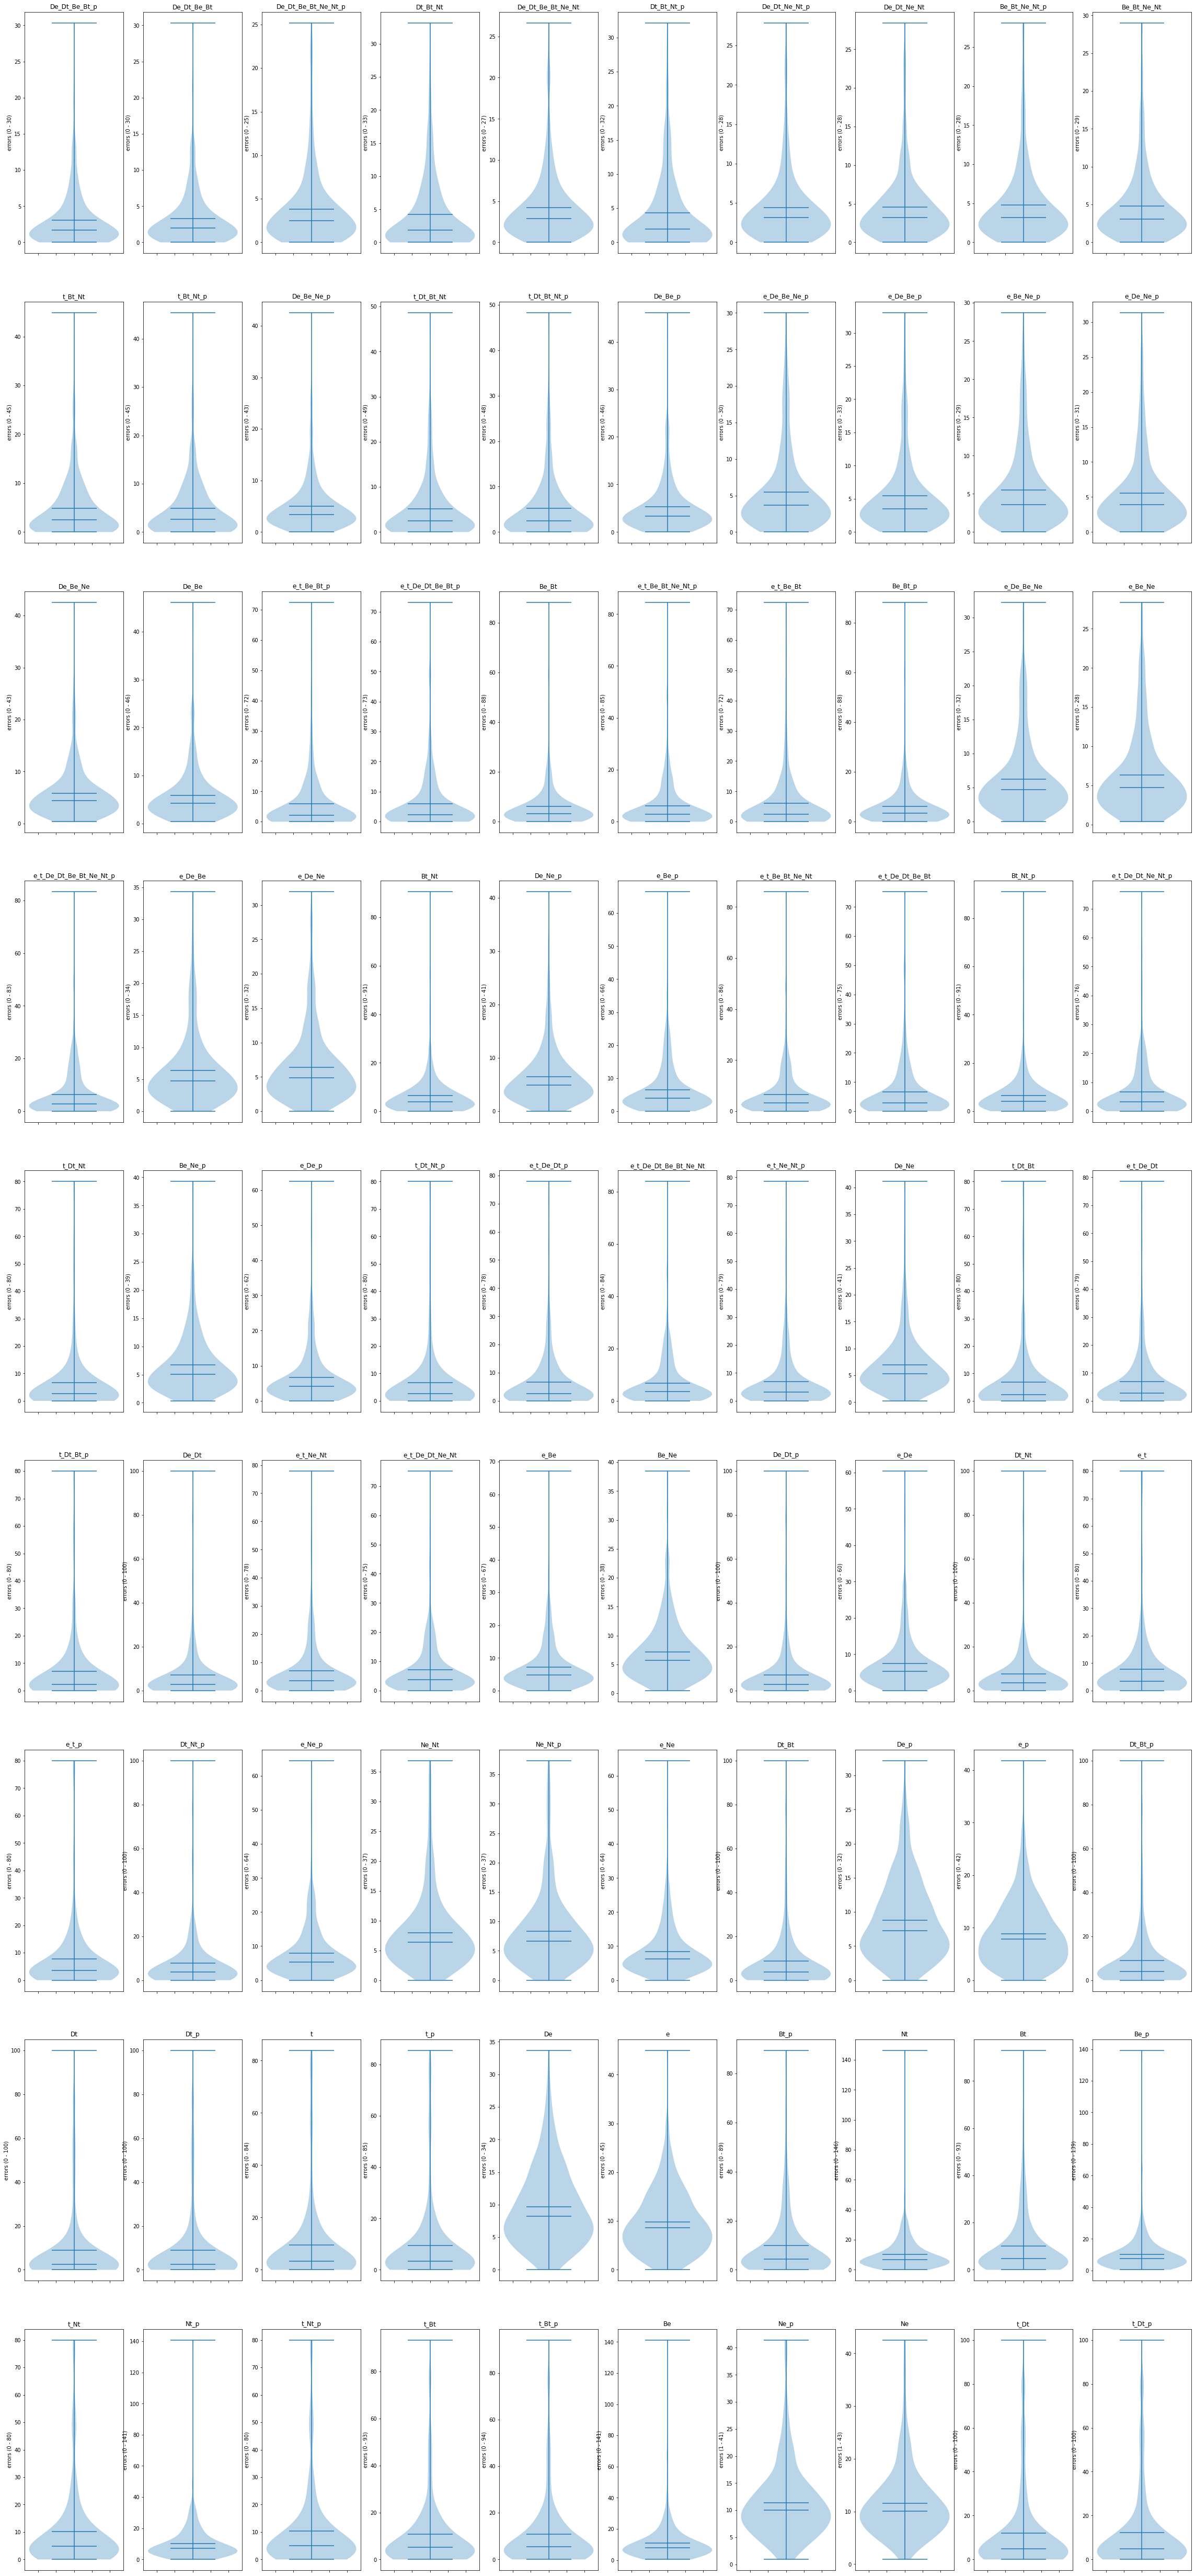

In [88]:
def get_violins():
    sql = """select actions, score, length(gold_text) as gold_len
               from ocr_scores
               join gold_standard using (gold_id)
              where score_set = ?
                and ocr_scores.gold_set = ?"""
    with db.connect(ARGS.database) as cxn:
        scores = db.execute(cxn, sql, [ARGS.score_set, ARGS.gold_set])

    pipeline_dict = PipelinesDict()

    for score in scores:
        pipeline_dict[score["actions"]].add_score(score["score"], score["gold_len"])

    height = 10
    rows = 9
    cols = 10
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(40, height * rows))

    for i, pipe in enumerate(pipeline_dict):
        r = i // cols
        c = i % cols
        axes[r, c].violinplot(
            pipe.scores,
            showextrema=True,
            showmedians=True,
            showmeans=True,
        )
        mx = round(max(pipe.scores))
        mn = round(min(pipe.scores))
        title = encode_actions(pipe.actions)
        title = title.strip("_")
        title = re.sub(r"__+", "_", title)
        title = re.sub(r"-", "", title)
        axes[r, c].set_title(title)
        axes[r, c].set_ylabel(f"errors ({mn} - {mx})")
        axes[r, c].set_xticklabels([])

    path = consts.DATA_DIR / "output" / "graphs" / "violinplot.jpg"
    plt.savefig(path, format="jpg")
    plt.show()

    return pipeline_dict


pipeline_violins = get_violins()

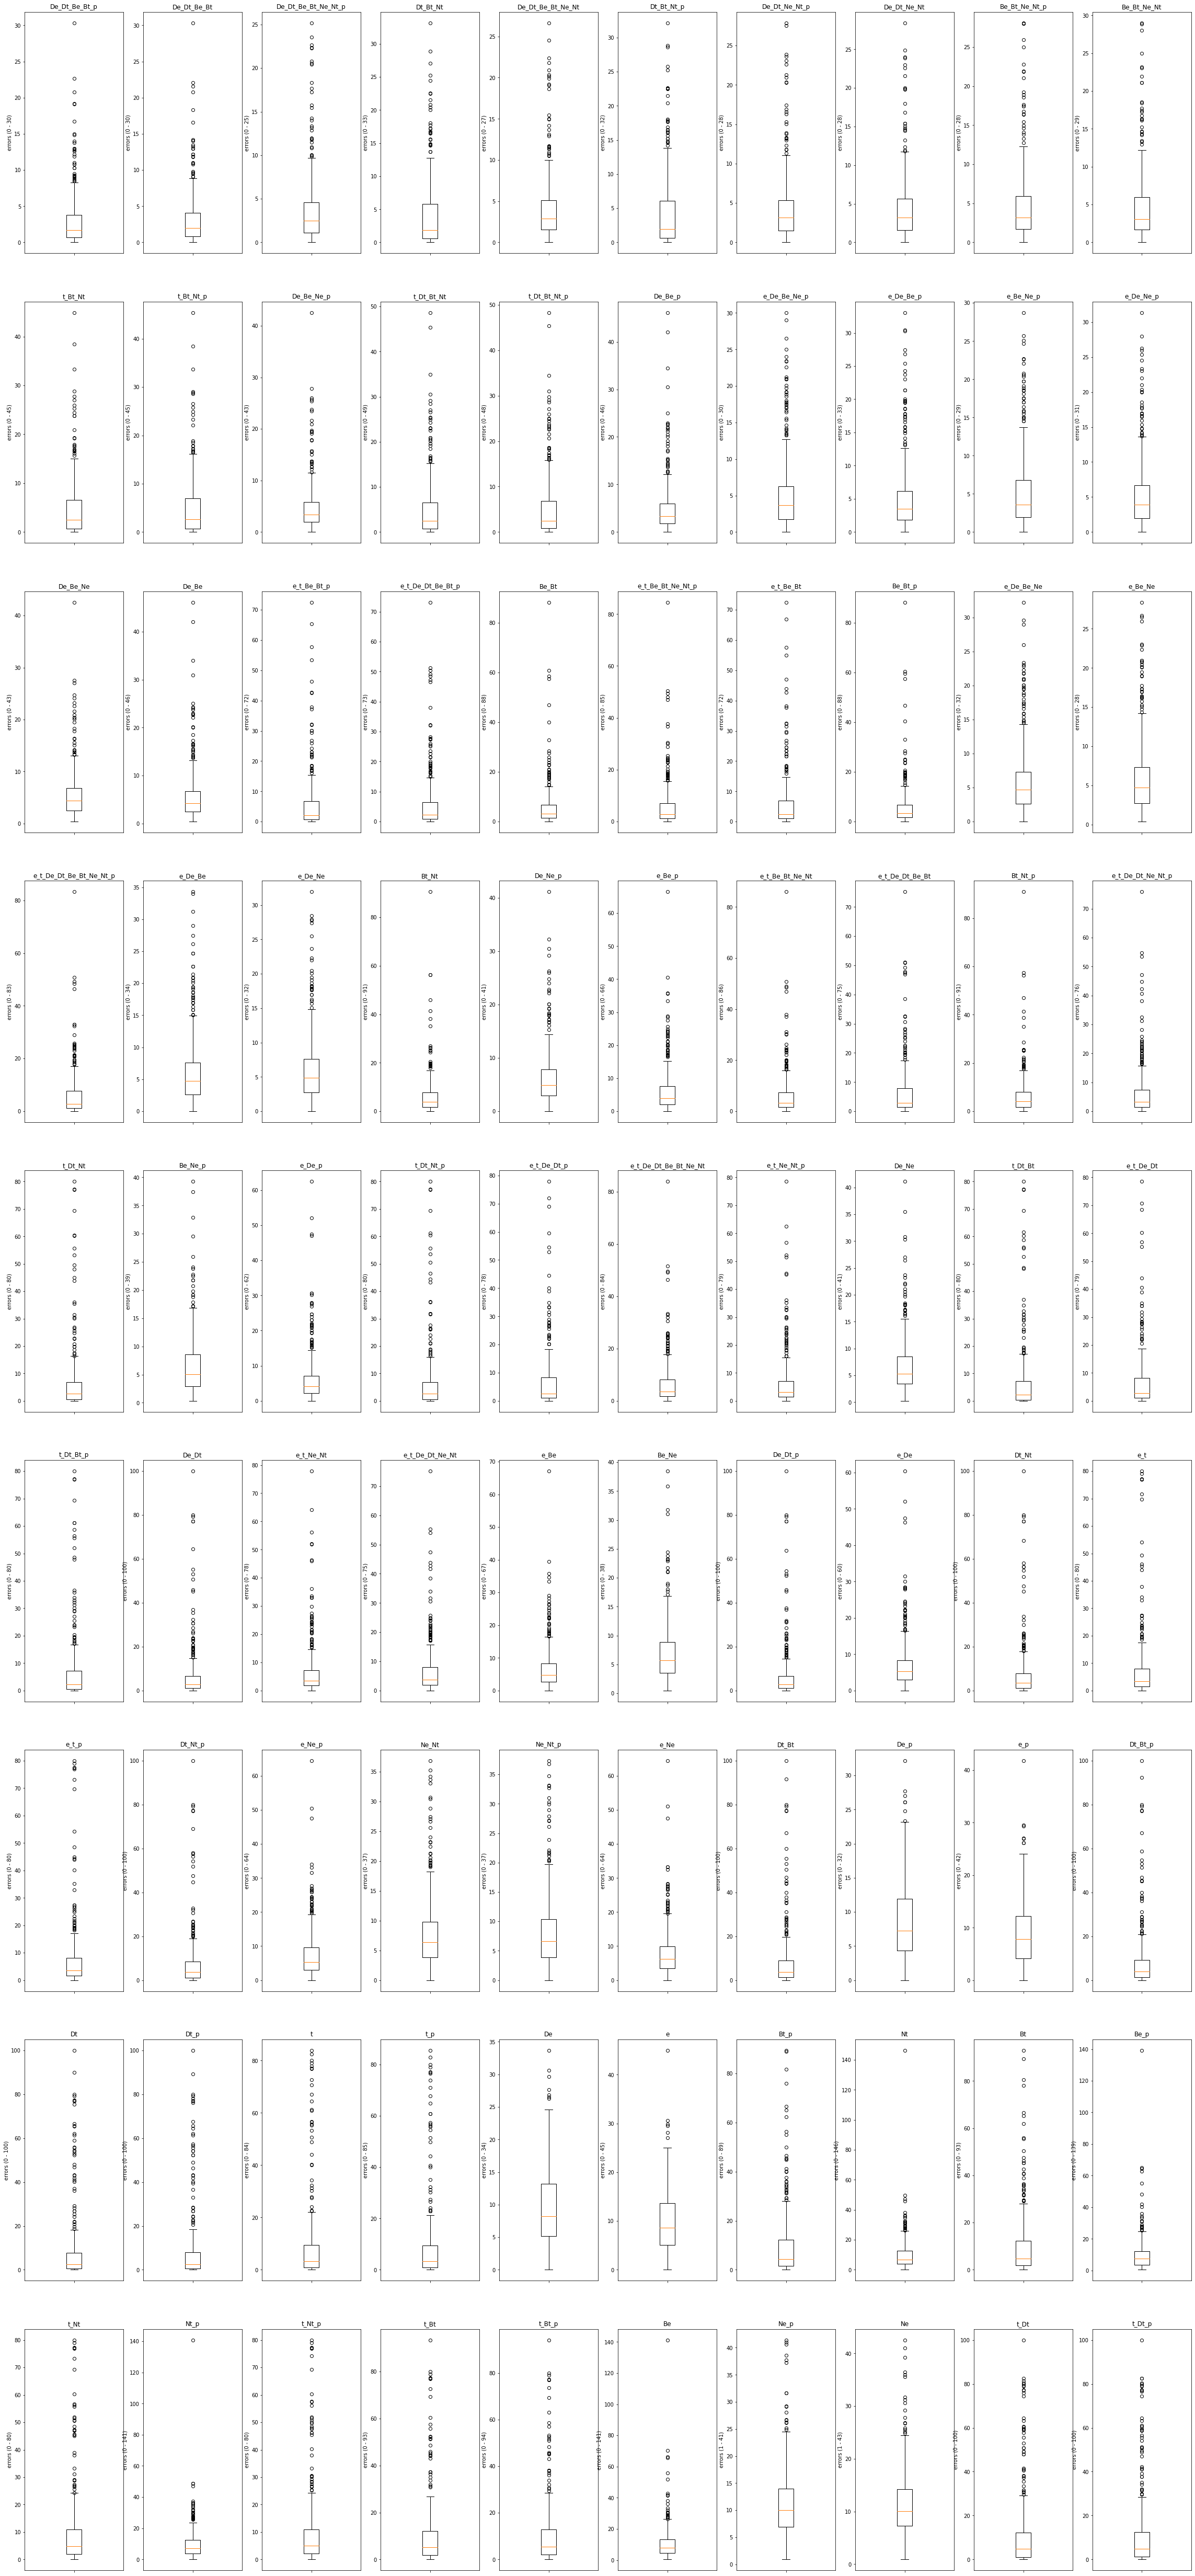

In [89]:
def get_boxes():
    sql = """select actions, score, length(gold_text) as gold_len
               from ocr_scores
               join gold_standard using (gold_id)
              where score_set = ?
                and ocr_scores.gold_set = ?"""
    with db.connect(ARGS.database) as cxn:
        scores = db.execute(cxn, sql, [ARGS.score_set, ARGS.gold_set])

    pipeline_dict = PipelinesDict()

    for score in scores:
        pipeline_dict[score["actions"]].add_score(score["score"], score["gold_len"])

    height = 10
    rows = 9
    cols = 10
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(40, height * rows))

    for i, pipe in enumerate(pipeline_dict):
        r = i // cols
        c = i % cols
        axes[r, c].boxplot(
            pipe.scores,
        )
        mx = round(max(pipe.scores))
        mn = round(min(pipe.scores))
        title = encode_actions(pipe.actions)
        title = title.strip("_")
        title = re.sub(r"__+", "_", title)
        title = re.sub(r"-", "", title)
        axes[r, c].set_title(title)
        axes[r, c].set_ylabel(f"errors ({mn} - {mx})")
        axes[r, c].set_xticklabels([])

    path = consts.DATA_DIR / "output" / "graphs" / "boxplot.jpg"
    plt.savefig(path, format="jpg")
    plt.show()

    return pipeline_dict


pipeline_boxes = get_boxes()

## Total scores by pipeline

In [11]:
PipelineScore = namedtuple("PipelineScore", "score pipeline")


def scores_by_pipeline(scores, gold_std):
    tally = defaultdict(int)

    for score in scores:
        tally[score["actions"]] += score["score"]

    tally = [(v, len(k), k) for k, v in tally.items()]
    tally = sorted(tally)

    return [PipelineScore(t[0], t[2]) for t in tally]


# summed = scores_by_pipeline(SCORES, GOLD_DICT)
# for sum_ in summed:
#     print(sum_)

## Output how many times a pipeline was the best

In [12]:
PipelineWinner = namedtuple("PipelineWinner", "count pipeline")


def winners_by_pipeline(all_scores, gold_std):
    tally = defaultdict(int)
    grouped_scores = groupby(all_scores, key=lambda s: s["label_id"])

    for label_id, scores in grouped_scores:
        scores = list(scores)

        min_score = min(s["score"] for s in scores)
        for score in scores:
            if score["score"] == min_score:
                tally[score["actions"]] += 1

    tally = [(v, -len(k), k) for k, v in tally.items()]
    tally = sorted(tally, reverse=True)
    return [PipelineWinner(t[0], t[2]) for t in tally]


# winners = winners_by_pipeline(SCORES, GOLD_DICT)
# for win in winners:
#     print(win)

# Distribution of scores per pipeline

## Output best scores

In [13]:
def html_top_scores(scores, gold_std, line_align):
    grouped_scores = groupby(scores, key=lambda s: s["label_id"])

    for label_id, scores in tqdm(grouped_scores):
        scores = list(scores)

        gold = gold_std[scores[0]["gold_id"]]

        min_score = min(s["score"] for s in scores)

        counts = defaultdict(int)
        for s in scores:
            counts[s["score"]] += 1
        counts = sorted(counts.items())

        plt.bar([c[0] for c in counts], [c[1] for c in counts])
        graph = (
            consts.DATA_DIR
            / "output"
            / "graphs"
            / f"lb_{gold['sheet_id']:06d}_{gold['label_id']:08d}.svg"
        )
        plt.savefig(graph, format="svg")
        plt.close()

        # Shrink actions to codes
        actions = [f"gold {'__ ' * 7}"]
        for acts in [
            json.loads(s["actions"]) for s in scores if s["score"] == min_score
        ]:
            pipe = [c if a in acts else "__" for a, c in ACTIONS]
            actions.append(" ".join(pipe))

        top = [gold["gold_text"]]
        top += [s["score_text"] for s in scores if s["score"] == min_score]

        top = [" ".join(ln.split()) for ln in top]

        # print(f"{label_id}  {min_score}  {len(top) - 1}")

        aligned = line_align.align(top)

        rows = len(aligned)
        cols = len(aligned[0])
        colored = [list(a) for a in aligned]

        for col in range(cols):
            col_chars = [aligned[row][col] for row in range(rows)]
            if len(set(col_chars)) > 1:
                for i, row in enumerate(range(rows)):
                    if i == 0:
                        colored[row][
                            col
                        ] = f'<span class="yellow">{aligned[row][col]}</span>'
                    elif aligned[0][col] != aligned[row][col]:
                        colored[row][
                            col
                        ] = f'<span class="green">{aligned[row][col]}</span>'

        colored = ["".join(ln) for ln in colored]
        gold["colored"] = list(zip(actions, colored))
        gold["min_score"] = min_score
        gold["path"] = f"lb_{gold['sheet_id']:06d}_{gold['label_id']:08d}.jpg"
        gold["graph"] = f"lb_{gold['sheet_id']:06d}_{gold['label_id']:08d}.svg"


# html_top_scores(SCORES, GOLD_DICT, scorer.line_align)

In [14]:
def write_html(gold_std):
    env = jinja2.Environment(
        loader=jinja2.FileSystemLoader("assets/"),
        autoescape=True,
    )

    template = env.get_template("html_template.html").render(
        now=datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M"),
        golden=gold_std,
    )

    with open(ARGS.out_file, "w", encoding="utf_8") as html_file:
        html_file.write(template)


# write_html(GOLD_DICT)